In [101]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import os
import sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
sys.path.append('../..')
from src.data.functions import safe_log, convert_datetime
from src.utils.directories import get_parent_directory

import sys
import os
sys.path.append('../..')
from src.features.processing_func import mld
from src.features.calc_seaice import calc_SIC
from src.utils.directories import get_parent_directory

Use ascos_mat_to_nc.m file, from src/data folder and run in matlab to generate the nc file.

In [19]:
parent_dir = get_parent_directory()
ascos_nc = os.path.join(parent_dir, "data/interim/ASCOS_data.nc")
ascos_ds = xr.open_dataset(ascos_nc)

In [88]:
formatted_ds = ascos_ds.rename_vars({"epsilon": "eps", "latitude": "old_lat", "longitude": "old_lon"})
# Convert the time coordinate into a variable
formatted_ds = formatted_ds.assign(yday=ascos_ds.coords['time'])
formatted_ds = formatted_ds.rename({"time": "profile"})

In [90]:
dataset = formatted_ds

# Copy latitude values
latitude = dataset.old_lat.copy()

# Create a new variable with 'profile' dimension
new_latitude = xr.DataArray(latitude, dims=['profile'], coords={'profile': dataset.profile})

# Add the new variable to the dataset
dataset['latitude'] = new_latitude

# Copy longitude values
longitude = dataset.old_lon.copy()

# Create a new variable with 'profile' dimension
new_longitude = xr.DataArray(longitude, dims=['profile'], coords={'profile': dataset.profile})

# Add the new variable to the dataset
dataset['longitude'] = new_longitude

# Drop the dimension you want to remove
dataset = dataset.drop_vars({'old_lat', 'old_lon'})

## Convert year day to datetime

In [93]:
from datetime import datetime, timedelta

def add_datetime_variable(dataset, variable_name, year):
    # Extract the day of the year variable
    day_of_year = dataset[variable_name]

    # Create an empty list to store datetime values
    datetime_values = []

    # Iterate over each value in the day of the year variable
    for day in day_of_year.values:
        # Create a datetime object
        date = datetime(year, 1, 1) + timedelta(days=day - 1)
        # Append the datetime object to the list
        datetime_values.append(date)

    # Convert the list to a DataArray with the appropriate dimensions and coordinates
    datetime_array = xr.DataArray(datetime_values, dims=day_of_year.dims, coords=day_of_year.coords)

    # Add the datetime variable to the dataset
    dataset["time"] = datetime_array

    return dataset

In [96]:
dataset = add_datetime_variable(dataset, "yday", 2008)

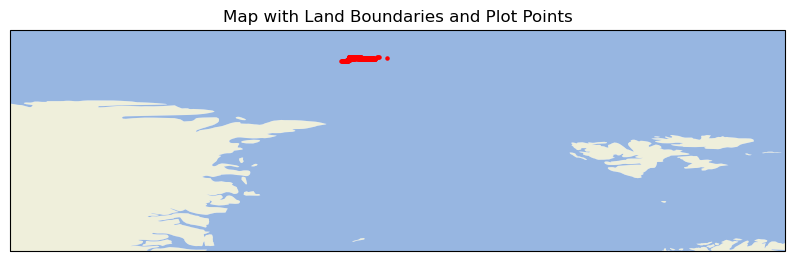

In [92]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.scatter(ascos_ds.longitude, ascos_ds.latitude, transform=ccrs.PlateCarree(), color='red', s=5)

# Add land, ocean, and borders
ax.add_feature(cfeature.LAND.with_scale('50m'))
ax.add_feature(cfeature.OCEAN.with_scale('50m'))

ax.set_extent([-40,30, 70, 90], crs=ccrs.PlateCarree())
ax.set_title("Map with Land Boundaries and Plot Points")
plt.show()

## Check if it works with the variables

ensure it is in (profile, depth) shape

In [111]:
SI_HadISST = os.path.join(parent_dir, "data/external/SI-area/HadISST_ice.nc")
Hadi_SI = xr.open_dataset(SI_HadISST)

In [102]:
from src.features.processing_func import mld
from src.features.calc_seaice import calc_SIC

In [112]:
ASCOS_SIC = calc_SIC(dataset, Hadi_SI)

In [122]:
dataset = dataset.transpose("depth", "profile")

In [123]:
ASCOS_MLD = mld(dataset)

## Save in datafolder

In [124]:
# Construct the file path using the parent directory
file_path = os.path.join(parent_dir, "data", "interim", "ascos_ds.nc")
dataset.to_netcdf(file_path)